In [1]:
import dill as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Process Scraped Data

In [2]:
with open("../data/intermediate/cpu_specs_raw_tables.pkl", "rb") as f:
    payload = pickle.load(f)

In [3]:
for k in payload:
    print(k)

tables
errors
resolved
unresolved


In [4]:
models = [k for k in payload["tables"]]
print(models)

['AMD Ryzen 9 9950X', 'AMD RYZEN AI MAX+ 395', 'Intel Core i9-13900K', 'AMD Ryzen 7 7700X', 'AMD Ryzen 9 7950X', 'Intel Core i9-14900K', 'AMD EPYC 4364P', 'AMD Ryzen 9 7900X', 'Intel Core i9-12900K', 'AMD EPYC 4564P', 'AMD EPYC 4464P', 'AMD EPYC 4584PX', 'AMD EPYC 4484PX', 'AMD Ryzen 9 5900X', 'AMD Ryzen 5 7600X', 'Intel Core i9-11900K', 'AMD Ryzen 9 5950X', 'AMD Ryzen 7 5800X', 'AMD Ryzen 7 5800X3D', 'Intel Core i9-10900K', 'Intel Core i5-13600K', 'AMD EPYC 4124P', 'AMD Ryzen Threadripper 3970X', 'AMD Ryzen Threadripper 3990X', 'AMD Ryzen 9 3900XT', 'Intel Core i5-12600K', 'Intel Core i7-7900X', 'Intel Core i5-11600K', 'Intel Core i9-7980XE', 'Intel Core i5-13400', 'AMD Ryzen 7 PRO 5850U', 'AMD Ryzen Threadripper 2990WX', 'AMD Ryzen 7 PRO 6850U', 'AMD Ryzen 5 3600XT', 'AMD EPYC 73F3', 'AMD EPYC 75F3', 'AMD Ryzen Threadripper 3960X', 'AMD EPYC 74F3', 'Intel Xeon E-2278GEL', 'AMD Ryzen 7 1700 Eight-Core', 'AMD EPYC 7713', 'Intel Core i9-9900KS', 'AMD EPYC 7F52', 'Intel Core i9-9900K', '

In [5]:
for k in payload["tables"][models[0]]:
    print(k)

                   0               1
0            Socket:  AMD Socket AM5
1           Foundry:            TSMC
2      Process Size:            4 nm
3       Transistors:  16,630 million
4          Die Size:     2x 70.6 mm²
5  I/O Process Size:            6 nm
6   I/O Transistors:   3,400 million
7      I/O Die Size:         122 mm²
8           Package:      FC-LGA1718
9             tJMax:            95°C
                    0               1
0             Market:         Desktop
1  Production Status:          Active
2       Release Date:  Aug 15th, 2024
3       Launch Price:            $649
4              Part#:   100-000001277
5     Bundled Cooler:             NaN
                      0              1
0            Frequency:        4.3 GHz
1          Turbo Clock:  up to 5.7 GHz
2           Base Clock:        100 MHz
3           Multiplier:          43.0x
4  Multiplier Unlocked:            Yes
5                  TDP:          170 W
6                  PPT:          230 W
               

In [6]:
print(type(payload["tables"][models[0]]))

<class 'list'>


Need to figure out the best way to flatten these dataframes.

In [7]:
import pandas as pd
import re

def two_col_df_to_series(df: pd.DataFrame) -> pd.Series:
    """
    Convert a 2-column DataFrame like:

        0              1
        Socket:        AMD Socket AM5
        Foundry:       TSMC
        Process Size:  5 nm

    into a Series:

        socket          AMD Socket AM5
        foundry         TSMC
        process_size    5 nm
    """
    if df is None or df.empty or df.shape[1] != 2:
        return pd.Series(dtype=object)

    # Raw labels and values
    labels = df.iloc[:, 0].astype(str)
    values = df.iloc[:, 1]

    # Normalize labels a bit (optional but helpful)
    labels = (
        labels.str.strip()
              .str.replace(":", "", regex=False)
              .str.lower()
              .str.replace(r"\s+", "_", regex=True)
    )

    s = pd.Series(values.to_numpy(), index=labels)

    # If the same label appears multiple times in this DF, keep the first
    s = s[~s.index.duplicated(keep="first")]

    return s

def two_col_df_to_series(df: pd.DataFrame) -> pd.Series:
    """
    Convert a 2-column DataFrame like:

        0              1
        Socket:        AMD Socket AM5
        Foundry:       TSMC
        Process Size:  5 nm

    into a Series:

        socket          AMD Socket AM5
        foundry         TSMC
        process_size    5 nm
    """
    if df is None or df.empty or df.shape[1] != 2:
        return pd.Series(dtype=object)

    # Raw labels and values
    labels = df.iloc[:, 0].astype(str)
    values = df.iloc[:, 1]

    # Normalize labels a bit (optional but helpful)
    labels = (
        labels.str.strip()
              .str.replace(":", "", regex=False)
              .str.lower()
              .str.replace(r"\s+", "_", regex=True)
    )

    s = pd.Series(values.to_numpy(), index=labels)

    # If the same label appears multiple times in this DF, keep the first
    s = s[~s.index.duplicated(keep="first")]

    return s

def list_of_dfs_to_row(dfs) -> pd.Series:
    """
    dfs: list of DataFrames (some may be 1-col, 2-col, None, etc.)

    Returns: a Series representing one "item" / row of the final big table.
    """
    parts = []

    for df in dfs:
        if df is None:
            continue

        # Only use 2-column DataFrames
        if isinstance(df, pd.DataFrame) and df.shape[1] == 2:
            s = two_col_df_to_series(df)
            if not s.empty:
                parts.append(s)

    if not parts:
        return pd.Series(dtype=object)

    row = pd.concat(parts)

    # If a label appears in multiple 2-col tables for this item, keep first
    row = row[~row.index.duplicated(keep="first")]

    return row


In [8]:
rows = [list_of_dfs_to_row(payload["tables"][model]) for model in models]

big = pd.DataFrame(rows)

In [9]:
list(big.columns)

['socket',
 'foundry',
 'process_size',
 'transistors',
 'die_size',
 'i/o_process_size',
 'i/o_transistors',
 'i/o_die_size',
 'package',
 'tjmax',
 'market',
 'production_status',
 'release_date',
 'launch_price',
 'part#',
 'bundled_cooler',
 'frequency',
 'turbo_clock',
 'base_clock',
 'multiplier',
 'multiplier_unlocked',
 'tdp',
 'ppt',
 'codename',
 'generation',
 'memory_support',
 'rated_speed',
 'memory_bus',
 'memory_bandwidth',
 'ecc_memory',
 'pci-express',
 'chipsets',
 '#_of_cores',
 '#_of_threads',
 'smp_#_cpus',
 'integrated_graphics',
 'cache_l1',
 'cache_l2',
 'cache_l3',
 'npu',
 'configurable_tdp',
 'memory_capacity',
 'tcasemax',
 'retail_launch',
 'p-core_turbo',
 'p-core_boost_3.0',
 'e-core_frequency',
 'pl1',
 'pl2',
 'pl2_tau_limit',
 'ddr4_speed',
 'ddr5_speed',
 'secondary_pcie',
 'hybrid_cores',
 'e-core_l1',
 'e-core_l2',
 'xfr',
 '3d_v-cache',
 'tdp-down_frequency',
 'boost_3.0',
 'boost_2.0',
 'configurable_tdp-down',
 'boost_3.0_frequency',
 'fp32',
 '

In [10]:
big["Model"]=models

In [11]:
last_col = big.columns[-1]   # name of last column
col_data = big.pop(last_col) # remove it (and get the Series)
big.insert(0, last_col, col_data)  # insert at position 0

In [12]:
big

,Model,socket,foundry,process_size,transistors,die_size,i/o_process_size,i/o_transistors,i/o_die_size,package,...,tertiary_pcie,lp_e-cores,e-core_l3,avx2_turbo,avx-512_turbo,2_dpc_ram_speed,max_power,packaged_memory,pch_pcie,ddr3l_speed
0,AMD Ryzen 9 9950X,AMD Socket AM5,TSMC,4 nm,"16,630 million",2x 70.6 mm²,6 nm,"3,400 million",122 mm²,FC-LGA1718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMD RYZEN AI MAX+ 395,AMD Socket FP11,TSMC,4 nm,NaN,2x 70.6 mm²,NaN,NaN,308 mm²,FC-BGA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Intel Core i9-13900K,Intel Socket 1700,Intel,10 nm,NaN,257 mm²,NaN,NaN,NaN,FC-LGA16A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AMD Ryzen 7 7700X,AMD Socket AM5,TSMC,5 nm,"6,570 million",71 mm²,6 nm,NaN,122 mm²,FC-LGA1718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMD Ryzen 9 7950X,AMD Socket AM5,TSMC,5 nm,"13,140 million",2x 71 mm²,6 nm,NaN,122 mm²,FC-LGA1718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,Intel Xeon E5-2687W 0,Intel Socket 2011,Intel,32 nm,"2,270 million",435 mm²,NaN,NaN,NaN,FC-LGA10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,Intel Core i7-12700KF,Intel Socket 1700,Intel,10 nm,NaN,215 mm²,NaN,NaN,NaN,FC-LGA16A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,Intel Xeon Gold 6144,Intel Socket 3647,Intel,14 nm,"8,000 million",NaN,NaN,NaN,NaN,FC-LGA3647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,Intel Core i7-1185G7E,Intel BGA 1449,Intel,10 nm,NaN,144 mm²,NaN,NaN,NaN,FC-BGA1449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
big.to_csv("../data/intermediate/CPU-Specs-Full.csv",index=False)

### Merge Scores with Specifications

In [14]:
missing_vals = big.isna().sum()
missing_vals

0
Model                0
socket               0
foundry              3
process_size         0
transistors        160
                  ... 
2_dpc_ram_speed    428
max_power          427
packaged_memory    427
pch_pcie           428
ddr3l_speed        428
Length: 127, dtype: int64

In [15]:
print(len(big))
len(missing_vals[missing_vals>0.25*len(big)])
percents = np.linspace(0,1,101)
missing_num = percents*len(big)
print(missing_num)
missing = [len(missing_vals[missing_vals>int(num)])/len(big.columns) for num in missing_num]

429
[  0.     4.29   8.58  12.87  17.16  21.45  25.74  30.03  34.32  38.61
  42.9   47.19  51.48  55.77  60.06  64.35  68.64  72.93  77.22  81.51
  85.8   90.09  94.38  98.67 102.96 107.25 111.54 115.83 120.12 124.41
 128.7  132.99 137.28 141.57 145.86 150.15 154.44 158.73 163.02 167.31
 171.6  175.89 180.18 184.47 188.76 193.05 197.34 201.63 205.92 210.21
 214.5  218.79 223.08 227.37 231.66 235.95 240.24 244.53 248.82 253.11
 257.4  261.69 265.98 270.27 274.56 278.85 283.14 287.43 291.72 296.01
 300.3  304.59 308.88 313.17 317.46 321.75 326.04 330.33 334.62 338.91
 343.2  347.49 351.78 356.07 360.36 364.65 368.94 373.23 377.52 381.81
 386.1  390.39 394.68 398.97 403.26 407.55 411.84 416.13 420.42 424.71
 429.  ]


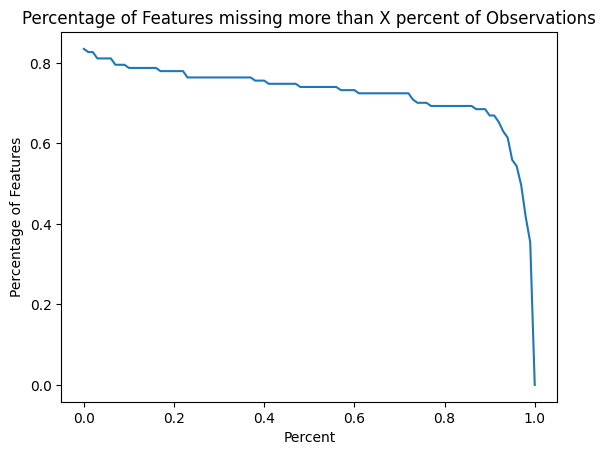

In [16]:
plt.figure()
plt.plot(percents,missing,linestyle="-")
plt.title("Percentage of Features missing more than X percent of Observations")
plt.ylabel("Percentage of Features")
plt.xlabel("Percent")
plt.show()

The general relative flatness of the missingness curve suggests that it is probably a common set of features which are generally missing observations. As such, we can probably choose to omit the columns which are missing more than some arbitrary percentage between 10\% and  80\% of observations. We use the cutoff 0.2, based on the intuition that 30\% missingness is unlikely to be catastrophic for downstream analyses without being too strict to exclude important but occasionally missing features

In [17]:
reduced = missing_vals[missing_vals>int(0.5*len(big))]
cols_to_drop = list(reduced.index)
cols_to_drop
print(cols_to_drop)
print(len(cols_to_drop)/len(big.columns))

['i/o_process_size', 'i/o_transistors', 'i/o_die_size', 'tjmax', 'bundled_cooler', 'ppt', 'chipsets', 'npu', 'configurable_tdp', 'memory_capacity', 'tcasemax', 'retail_launch', 'p-core_turbo', 'p-core_boost_3.0', 'e-core_frequency', 'pl1', 'pl2', 'pl2_tau_limit', 'ddr4_speed', 'ddr5_speed', 'secondary_pcie', 'hybrid_cores', 'e-core_l1', 'e-core_l2', 'xfr', '3d_v-cache', 'tdp-down_frequency', 'boost_3.0', 'boost_2.0', 'configurable_tdp-down', 'boost_3.0_frequency', 'fp32', 'chipset', 'lpddr4x_speed', 'lpddr5_speed', '#_of_ccds', 'cores_per_ccd', 'all-core_turbo', 'lpddr4_speed', 'all_core_turbo', 'per-socket_pci-express', 'total_l3', 'adjustable_multiplier', 'qpi_links', 'tdp-down_freq.', 'tdp-up_freq.', 'lpddr3_speed', 'msrp', 'tdp_range', 'voltage', 'max._memory', 'mcr_dimm_speed', 'cxl', 'upi_links', 'avx-512_fma_ports', '2dpc_rated_speed', 'high_priority_core_freq.', 'low_priority_core_freq.', 'high_priority_cores', 'low_priority_cores', 'chipset_pcie', 'package_hbm', 'pl2_"extreme"

So, now we plan on dropping about 75\% of the features.

In [18]:
model_specification_table = big.drop(columns=cols_to_drop)
model_specification_table

,Model,socket,foundry,process_size,transistors,die_size,package,market,production_status,release_date,...,memory_bandwidth,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,integrated_graphics,cache_l1,cache_l2,cache_l3
0,AMD Ryzen 9 9950X,AMD Socket AM5,TSMC,4 nm,"16,630 million",2x 70.6 mm²,FC-LGA1718,Desktop,Active,"Aug 15th, 2024",...,89.6 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,80 KB (per core),1 MB (per core),64 MB (shared)
1,AMD RYZEN AI MAX+ 395,AMD Socket FP11,TSMC,4 nm,NaN,2x 70.6 mm²,FC-BGA,Mobile,Active,"Jan 6th, 2025",...,256.0 GB/s,Yes,"Gen 4, 16 Lanes (CPU only)",16,32,1,Radeon 8060S,80 KB (per core),1 MB (per core),64 MB (shared)
2,Intel Core i9-13900K,Intel Socket 1700,Intel,10 nm,NaN,257 mm²,FC-LGA16A,Desktop,Active,"Sep 27th, 2022",...,NaN,Yes,"Gen 5, 16 Lanes (CPU only)",24,32,1,UHD Graphics 770,80 KB (per core),2 MB (per core),36 MB (shared)
3,AMD Ryzen 7 7700X,AMD Socket AM5,TSMC,5 nm,"6,570 million",71 mm²,FC-LGA1718,Desktop,Active,"Sep 27th, 2022",...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",8,16,1,Radeon Graphics,64 KB (per core),1 MB (per core),32 MB (shared)
4,AMD Ryzen 9 7950X,AMD Socket AM5,TSMC,5 nm,"13,140 million",2x 71 mm²,FC-LGA1718,Desktop,Active,"Sep 27th, 2022",...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,64 KB (per core),1 MB (per core),64 MB (shared)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,Intel Xeon E5-2687W 0,Intel Socket 2011,Intel,32 nm,"2,270 million",435 mm²,FC-LGA10,Server/Workstation,unknown,"Mar 6th, 2012",...,NaN,Yes,Gen 3,8.0,16.0,2.0,NaN,64 KB (per core),256 KB (per core),20 MB (shared)
425,Intel Core i7-12700KF,Intel Socket 1700,Intel,10 nm,NaN,215 mm²,FC-LGA16A,Desktop,Active,"Nov 4th, 2021",...,NaN,No,"Gen 4, 20 Lanes (CPU only)",12,20,1,NaN,80 KB (per core),1.25 MB (per core),25 MB (shared)
426,Intel Xeon Gold 6144,Intel Socket 3647,Intel,14 nm,"8,000 million",NaN,FC-LGA3647,Server/Workstation,unknown,"Jul 11th, 2017",...,NaN,Yes,NaN,18.0,36.0,4.0,NaN,64 KB (per core),1 MB (per core),24.75 MB (shared)
427,Intel Core i7-1185G7E,Intel BGA 1449,Intel,10 nm,NaN,144 mm²,FC-BGA1449,Mobile,Active,"Sep 2nd, 2020",...,NaN,No,"Gen 4, 4 Lanes (CPU only)",4,8,1,Iris Xe-LP Graphics G7 96EU,80 KB (per core),1.25 MB (per core),12 MB (shared)


In [19]:
model_specification_table.columns

Index(['Model', 'socket', 'foundry', 'process_size', 'transistors', 'die_size',
       'package', 'market', 'production_status', 'release_date',
       'launch_price', 'part#', 'frequency', 'turbo_clock', 'base_clock',
       'multiplier', 'multiplier_unlocked', 'tdp', 'codename', 'generation',
       'memory_support', 'rated_speed', 'memory_bus', 'memory_bandwidth',
       'ecc_memory', 'pci-express', '#_of_cores', '#_of_threads', 'smp_#_cpus',
       'integrated_graphics', 'cache_l1', 'cache_l2', 'cache_l3'],
      dtype='object', name=0)

Now, I should join the data.

In [20]:
long_data = pd.read_csv("../data/intermediate/long_data.csv")

In [21]:
long_data

,Unnamed: 0,index,Component,Samples,Test,Units,Score,SD
0,0,0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40
1,1,1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181
2,2,2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242
3,3,3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53
4,4,4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608
...,...,...,...,...,...,...,...,...
1959,1959,2143,Intel Core i3-1005G1,4.0,tensorflow,Microseconds (Average),9975,7
1960,1960,2144,2 x AMD EPYC 7773X 64-Core,8.0,tensorflow,Microseconds (Average),10045,535
1961,1961,2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608
1962,1962,2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55


In [22]:
print(len(long_data["Component"].unique()))

489


Need to merge across components. 

Probably, by merge if the Component column contains (as a substring) the Model column. 

Alternatively, I can process the Component column in the same manner as I did the Model column.

In [23]:
import re

# Matches: "2 x", "2x", "2 ×" (case-insensitive), with optional spaces
_MULTIPLIER_RE = re.compile(r'^\s*(?P<multi>\d+)\s*(?:x|×)\s*', re.IGNORECASE)

# Matches a *trailing* core/thread suffix like:
#  "32-Core", "32 Core", "32C", optionally plus "/ 64-Thread", ", 64 Threads", "and 64T"
#  optionally wrapped in parentheses, e.g. "(32-Core / 64-Thread)"
_TRAILING_CORES_THREADS_RE = re.compile(
    r"""
    \s*                              
    (?:\(\s*)?                       
    (?:[/,]|and)?\s*                 
    \d+\s*-?\s*(?:core|cores|c)\b    
    (?:                              
        \s*(?:[/,]|and)\s*
        \d+\s*-?\s*(?:thread|threads|t)\b
    )?
    \s*(?:\)\s*)?                    
    \s*$                             
    """,
    re.IGNORECASE | re.VERBOSE,
)

def normalize_model_and_multiplier(raw: str) -> tuple[str, int]:
    """
    Returns (base_model, multiplier).
      - base_model has any leading "<n> x" stripped
        and any trailing "<n>-Core[/<m>-Thread]" stripped.
      - multiplier is the leading <n> (default 1).
    """
    s = raw.strip()

    # 1) Extract leading multiplier (default 1)
    multiplier = 1
    m = _MULTIPLIER_RE.match(s)
    if m:
        multiplier = int(m.group("multi"))
        s = s[m.end():]  # chop it off

    # 2) Remove trailing core/thread decorations (only at end)
    s = _TRAILING_CORES_THREADS_RE.sub("", s)

    # 3) Collapse internal whitespace
    s = " ".join(s.split())
    return s, multiplier



In [24]:
models = long_data["Component"]

In [25]:
clean_models = []
multipliers = []
for model in models:
    #print(model)
    clean, mult = normalize_model_and_multiplier(model)
    clean_models.append(clean)
    multipliers.append(mult)

model_comparisons = pd.DataFrame({"Model":models,"Cleaned":clean_models, "Multipliers":multipliers})
print(model_comparisons)

                           Model                Cleaned  Multipliers
0      AMD Ryzen 9 9950X 16-Core      AMD Ryzen 9 9950X            1
1          AMD RYZEN AI MAX+ 395  AMD RYZEN AI MAX+ 395            1
2           Intel Core i9-13900K   Intel Core i9-13900K            1
3       AMD Ryzen 7 7700X 8-Core      AMD Ryzen 7 7700X            1
4      AMD Ryzen 9 7950X 16-Core      AMD Ryzen 9 7950X            1
...                          ...                    ...          ...
1959        Intel Core i3-1005G1   Intel Core i3-1005G1            1
1960  2 x AMD EPYC 7773X 64-Core         AMD EPYC 7773X            2
1961           AMD Ryzen 3 3200U      AMD Ryzen 3 3200U            1
1962         Intel Core i3-3110M    Intel Core i3-3110M            1
1963          Intel Core i7-7700     Intel Core i7-7700            1

[1964 rows x 3 columns]


I guess we should look at what models are contained in long_data but not in our specifications database.

In [26]:
benchmarked = model_comparisons["Cleaned"].unique()
scraped = big["Model"].unique()

diff = [i for i in benchmarked if i not in scraped]
diff

['AMD Custom APU 0405',
 'AMD A12-9720P RADEON R7 12 COMPUTE CORES 4C+8G',
 'Intel Pentium N4200',
 'Intel Atom x5-Z8350']

So, relatively few models are actually excluded.

In [27]:
long_data["Model"]=model_comparisons["Cleaned"]
long_data["Multiplier"]=model_comparisons["Multipliers"]
long_data

,Unnamed: 0,index,Component,Samples,Test,Units,Score,SD,Model,Multiplier
0,0,0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1
1,1,1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1
2,2,2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1
3,3,3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1
4,4,4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1
...,...,...,...,...,...,...,...,...,...,...
1959,1959,2143,Intel Core i3-1005G1,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1
1960,1960,2144,2 x AMD EPYC 7773X 64-Core,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2
1961,1961,2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1
1962,1962,2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1


In [28]:
full_df = pd.merge(
    long_data,
    model_specification_table,
    left_on="Model",
    right_on="Model",
    how="inner"
)

In [29]:
full_df

,Unnamed: 0,index,Component,Samples,Test,Units,Score,SD,Model,Multiplier,...,memory_bandwidth,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,integrated_graphics,cache_l1,cache_l2,cache_l3
0,0,0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1,...,89.6 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,80 KB (per core),1 MB (per core),64 MB (shared)
1,1,1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1,...,256.0 GB/s,Yes,"Gen 4, 16 Lanes (CPU only)",16,32,1,Radeon 8060S,80 KB (per core),1 MB (per core),64 MB (shared)
2,2,2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1,...,NaN,Yes,"Gen 5, 16 Lanes (CPU only)",24,32,1,UHD Graphics 770,80 KB (per core),2 MB (per core),36 MB (shared)
3,3,3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1,...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",8,16,1,Radeon Graphics,64 KB (per core),1 MB (per core),32 MB (shared)
4,4,4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1,...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,64 KB (per core),1 MB (per core),64 MB (shared)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,1959,2143,Intel Core i3-1005G1,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1,...,51.2 GB/s,No,Gen 3,2,4,1,UHD Graphics,64 KB (per core),256 KB (per core),4 MB (shared)
1954,1960,2144,2 x AMD EPYC 7773X 64-Core,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2,...,204.8 GB/s,Yes,"Gen 4, 128 Lanes (CPU only)",64.0,128.0,2.0,NaN,64 KB (per core),512 KB (per core),768 MB (shared)
1955,1961,2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1,...,38.4 GB/s,No,Gen 3,2,4,1,Radeon Vega 3,96 KB (per core),512 KB (per core),4 MB (shared)
1956,1962,2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1,...,NaN,No,NaN,2,4,1,Intel HD 4000,64 KB (per core),256 KB (per core),3 MB (shared)


In [30]:
full_df.drop(columns=["Component","Unnamed: 0", "index"],inplace=True)

In [31]:
full_df

,Samples,Test,Units,Score,SD,Model,Multiplier,socket,foundry,process_size,...,memory_bandwidth,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,integrated_graphics,cache_l1,cache_l2,cache_l3
0,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1,AMD Socket AM5,TSMC,4 nm,...,89.6 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,80 KB (per core),1 MB (per core),64 MB (shared)
1,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1,AMD Socket FP11,TSMC,4 nm,...,256.0 GB/s,Yes,"Gen 4, 16 Lanes (CPU only)",16,32,1,Radeon 8060S,80 KB (per core),1 MB (per core),64 MB (shared)
2,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1,Intel Socket 1700,Intel,10 nm,...,NaN,Yes,"Gen 5, 16 Lanes (CPU only)",24,32,1,UHD Graphics 770,80 KB (per core),2 MB (per core),36 MB (shared)
3,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1,AMD Socket AM5,TSMC,5 nm,...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",8,16,1,Radeon Graphics,64 KB (per core),1 MB (per core),32 MB (shared)
4,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1,AMD Socket AM5,TSMC,5 nm,...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,64 KB (per core),1 MB (per core),64 MB (shared)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1,Intel BGA 1526,Intel,10 nm,...,51.2 GB/s,No,Gen 3,2,4,1,UHD Graphics,64 KB (per core),256 KB (per core),4 MB (shared)
1954,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2,AMD Socket SP3,TSMC,7 nm,...,204.8 GB/s,Yes,"Gen 4, 128 Lanes (CPU only)",64.0,128.0,2.0,NaN,64 KB (per core),512 KB (per core),768 MB (shared)
1955,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1,AMD Socket FP5,GlobalFoundries,14 nm,...,38.4 GB/s,No,Gen 3,2,4,1,Radeon Vega 3,96 KB (per core),512 KB (per core),4 MB (shared)
1956,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1,Intel Socket G2 (988B),Intel,22 nm,...,NaN,No,NaN,2,4,1,Intel HD 4000,64 KB (per core),256 KB (per core),3 MB (shared)


In [32]:
full_df.columns

Index(['Samples', 'Test', 'Units', 'Score', 'SD', 'Model', 'Multiplier',
       'socket', 'foundry', 'process_size', 'transistors', 'die_size',
       'package', 'market', 'production_status', 'release_date',
       'launch_price', 'part#', 'frequency', 'turbo_clock', 'base_clock',
       'multiplier', 'multiplier_unlocked', 'tdp', 'codename', 'generation',
       'memory_support', 'rated_speed', 'memory_bus', 'memory_bandwidth',
       'ecc_memory', 'pci-express', '#_of_cores', '#_of_threads', 'smp_#_cpus',
       'integrated_graphics', 'cache_l1', 'cache_l2', 'cache_l3'],
      dtype='object')

In [33]:
full_df.to_csv("../data/full_data.csv",index=False)

### Explore scores

This is primarily because I don't recall the exact meaning of different test results. I expect that many will need to be transformed in order to ensure that higher is better for all scores. For this purpose, I will look at the different scores in a case by case manner.

In [34]:
tests = list(full_df["Test"].unique())
units = []

for test in tests:
    subset = full_df[full_df["Test"]==test]
    units.append(subset["Units"].unique().item())
    print(f"TEST: {test}")
    print(subset[["Model","Test","Units","Score"]].head(5))
    print(subset[["Model","Test","Units","Score"]].tail(5))
    print()

TEST: FinanceBench
                   Model          Test         Units  Score
0      AMD Ryzen 9 9950X  FinanceBench  ms (Average)  25684
1  AMD RYZEN AI MAX+ 395  FinanceBench  ms (Average)  28695
2   Intel Core i9-13900K  FinanceBench  ms (Average)  30855
3      AMD Ryzen 7 7700X  FinanceBench  ms (Average)  31891
4      AMD Ryzen 9 7950X  FinanceBench  ms (Average)  31980
                     Model          Test         Units   Score
97           AMD EPYC 7551  FinanceBench  ms (Average)  162098
98     Intel Celeron G6900  FinanceBench  ms (Average)  182698
99          Intel Core i7-  FinanceBench  ms (Average)  192259
100  Intel Xeon E5-2609 v4  FinanceBench  ms (Average)  203957
101    Intel Core i7-4600U  FinanceBench  ms (Average)  288715

TEST: amg
                Model Test                      Units       Score
102  Intel Xeon 6980P  amg  Figure Of Merit (Average)  8110403243
103     AMD EPYC 9755  amg  Figure Of Merit (Average)  6236738724
104    AMD EPYC 9575F  amg  Figure

In [35]:
print(units)

['ms (Average)', 'Figure Of Merit (Average)', 'GFLOP/s (Average)', 'Seconds (Average)', 'CG Mflops (Average)', 'Seconds (Average)', 'Seconds (Average)', 'Score (Average)', 'Seconds (Average)', 'Seconds (Average)', 'Seconds (Average)', 'Milliseconds (Average)', 'Seconds (Average)', 'Nodes Per Second (Average)', 'Microseconds (Average)']


In [36]:
print(tests)

['FinanceBench', 'amg', 'hpcg', 'linux_kernel', 'miniFE', 'nqueens', 'numenta_nab', 'numpy', 'nwchem', 'openfoam', 'openradioss', 'pybench', 'specfem3d', 'stockfish', 'tensorflow']


Many of the scores clearly follow a given ordinal direction (temporal or FLOP rates). 

However, 'Figure of Merit' and 'Score', associated with the algebraic multigrid (amg) and numpy tests resp. bears further inspection. Per further investigation, the amg figure of merit score corresponds roughly to the number of sparse matrix nonzeros are processed per second during setup/solve of a 3D PDE. The numpy score is an inverted geometric mean of different per-kernel runtimes with higher is better.

These interpretations make some sense given the observed rankings. As AMD EPYC 9755 should be better than the Intel Core i7-3770K (for amg) and The AMD Ryzen 9 9950X3D should be better than the AMD A10-7850K (for numpy).

### Transform Scores
Now we want to transform the different scores such that higher is better. For the purposes of this investigation we won't worry about statistical concerns with the transformation. In later modeling we may need to use the delta method or related to preserve the measurement uncertainty.

/var/folders/d1/6vfxtbn15j3fg3hhd9t57q300000gn/T/ipykernel_17675/1357394688.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


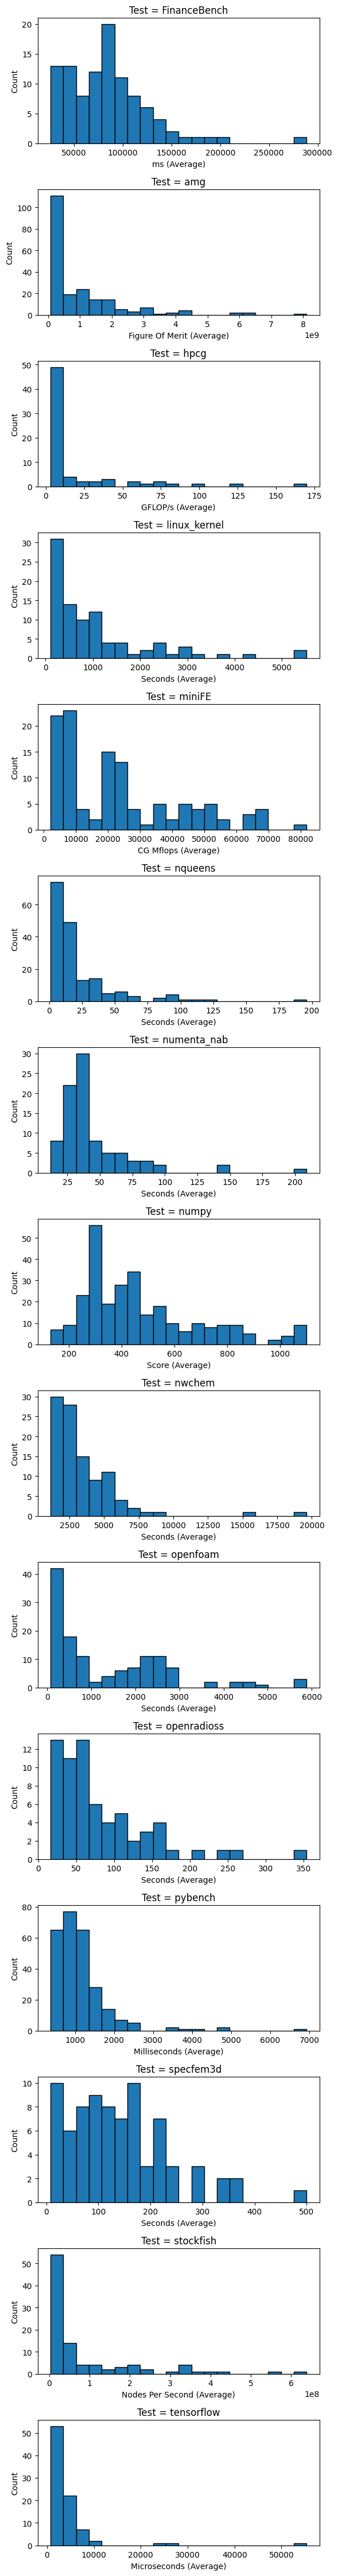

In [37]:
def make_group_hist(df, group_col, val_col, val_units):
    
    groups = df[group_col].unique()
    n_groups = len(groups)
    
    fig, axes = plt.subplots(
        n_groups, 1,
        figsize=(6, 3 * n_groups),
        #sharex=True,  # same x-axis for all
        #sharey=True   # same y-axis for all
    )
    
    # If there's only one group, axes is not an array, so make it a list
    if n_groups == 1:
        axes = [axes]
    
    for ax, g in zip(axes, groups):
        subset = df[df[group_col] == g]
        ax.hist(subset[val_col], bins=20, edgecolor="black")
        ax.set_title(f"{group_col} = {g}")
        ax.set_xlabel(subset[val_units].unique().item())
        ax.set_ylabel("Count")
    
    plt.tight_layout()
    return fig

fig = make_group_hist(full_df, "Test", "Score", "Units")
fig.show()

The above figures suggest we should utilize a log transform of the data for all scores.

In [38]:
# We need to transform by scaling in order to align with Higher is Better.
scaling = [-1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1]

for idx, test in enumerate(tests):
    mask = full_df["Test"] == test
    if scaling[idx]==-1:
        full_df.loc[mask, "Transformed Score"] = 1 / full_df.loc[mask, "Score"]
    else:
        full_df.loc[mask, "Transformed Score"] = full_df.loc[mask, "Score"]

In [39]:
full_df

,Samples,Test,Units,Score,SD,Model,Multiplier,socket,foundry,process_size,...,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,integrated_graphics,cache_l1,cache_l2,cache_l3,Transformed Score
0,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1,AMD Socket AM5,TSMC,4 nm,...,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,80 KB (per core),1 MB (per core),64 MB (shared),0.000039
1,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1,AMD Socket FP11,TSMC,4 nm,...,Yes,"Gen 4, 16 Lanes (CPU only)",16,32,1,Radeon 8060S,80 KB (per core),1 MB (per core),64 MB (shared),0.000035
2,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1,Intel Socket 1700,Intel,10 nm,...,Yes,"Gen 5, 16 Lanes (CPU only)",24,32,1,UHD Graphics 770,80 KB (per core),2 MB (per core),36 MB (shared),0.000032
3,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1,AMD Socket AM5,TSMC,5 nm,...,Yes,"Gen 5, 24 Lanes (CPU only)",8,16,1,Radeon Graphics,64 KB (per core),1 MB (per core),32 MB (shared),0.000031
4,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1,AMD Socket AM5,TSMC,5 nm,...,Yes,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,64 KB (per core),1 MB (per core),64 MB (shared),0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1,Intel BGA 1526,Intel,10 nm,...,No,Gen 3,2,4,1,UHD Graphics,64 KB (per core),256 KB (per core),4 MB (shared),0.000100
1954,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2,AMD Socket SP3,TSMC,7 nm,...,Yes,"Gen 4, 128 Lanes (CPU only)",64.0,128.0,2.0,NaN,64 KB (per core),512 KB (per core),768 MB (shared),0.000100
1955,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1,AMD Socket FP5,GlobalFoundries,14 nm,...,No,Gen 3,2,4,1,Radeon Vega 3,96 KB (per core),512 KB (per core),4 MB (shared),0.000043
1956,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1,Intel Socket G2 (988B),Intel,22 nm,...,No,NaN,2,4,1,Intel HD 4000,64 KB (per core),256 KB (per core),3 MB (shared),0.000036


/var/folders/d1/6vfxtbn15j3fg3hhd9t57q300000gn/T/ipykernel_17675/3434841778.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


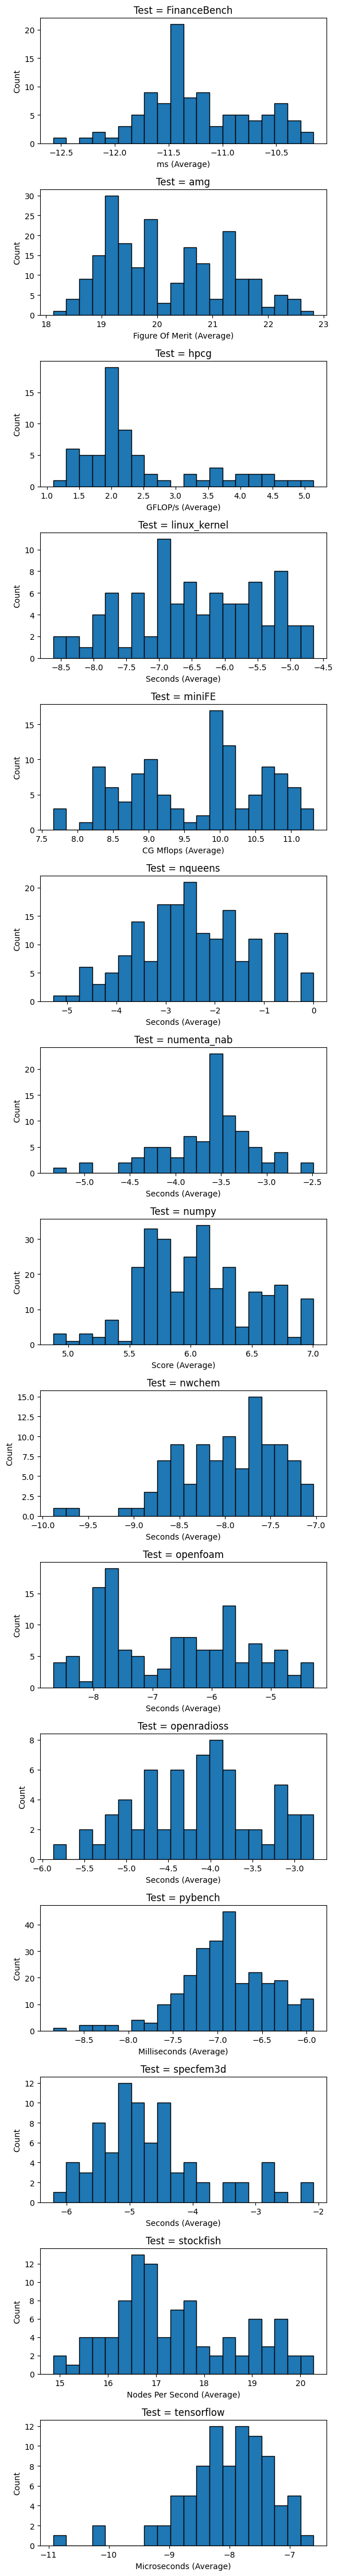

In [40]:
full_df["Log Scores"]=np.log(full_df["Transformed Score"])
fig = make_group_hist(full_df, "Test", "Log Scores", "Units")
fig.show()

In [41]:
full_df

,Samples,Test,Units,Score,SD,Model,Multiplier,socket,foundry,process_size,...,pci-express,#_of_cores,#_of_threads,smp_#_cpus,integrated_graphics,cache_l1,cache_l2,cache_l3,Transformed Score,Log Scores
0,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1,AMD Socket AM5,TSMC,4 nm,...,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,80 KB (per core),1 MB (per core),64 MB (shared),0.000039,-10.153624
1,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1,AMD Socket FP11,TSMC,4 nm,...,"Gen 4, 16 Lanes (CPU only)",16,32,1,Radeon 8060S,80 KB (per core),1 MB (per core),64 MB (shared),0.000035,-10.264478
2,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1,Intel Socket 1700,Intel,10 nm,...,"Gen 5, 16 Lanes (CPU only)",24,32,1,UHD Graphics 770,80 KB (per core),2 MB (per core),36 MB (shared),0.000032,-10.337054
3,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1,AMD Socket AM5,TSMC,5 nm,...,"Gen 5, 24 Lanes (CPU only)",8,16,1,Radeon Graphics,64 KB (per core),1 MB (per core),32 MB (shared),0.000031,-10.370079
4,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1,AMD Socket AM5,TSMC,5 nm,...,"Gen 5, 24 Lanes (CPU only)",16,32,1,Radeon Graphics,64 KB (per core),1 MB (per core),64 MB (shared),0.000031,-10.372866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1,Intel BGA 1526,Intel,10 nm,...,Gen 3,2,4,1,UHD Graphics,64 KB (per core),256 KB (per core),4 MB (shared),0.000100,-9.207837
1954,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2,AMD Socket SP3,TSMC,7 nm,...,"Gen 4, 128 Lanes (CPU only)",64.0,128.0,2.0,NaN,64 KB (per core),512 KB (per core),768 MB (shared),0.000100,-9.214830
1955,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1,AMD Socket FP5,GlobalFoundries,14 nm,...,Gen 3,2,4,1,Radeon Vega 3,96 KB (per core),512 KB (per core),4 MB (shared),0.000043,-10.060491
1956,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1,Intel Socket G2 (988B),Intel,22 nm,...,NaN,2,4,1,Intel HD 4000,64 KB (per core),256 KB (per core),3 MB (shared),0.000036,-10.219101


In [42]:
wide = full_df.pivot_table(
    index="Model",    # rows
    columns="Test", # columns become variable names
    values="Log Scores",     # cell values
    aggfunc="mean"      # in case there are duplicates; adjust as needed
)
wide.shape

(429, 15)

In [43]:
wide

Test,FinanceBench,amg,hpcg,linux_kernel,miniFE,nqueens,numenta_nab,numpy,nwchem,openfoam,openradioss,pybench,specfem3d,stockfish,tensorflow
Model,,,,,,,,,,,,,,,
AMD A10-7850K APU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.875197,NaN,NaN,NaN,-7.502738,NaN,NaN,NaN
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.927254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMD A6-3410MX APU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.507749,NaN,NaN,NaN
AMD Athlon 3000G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.533389,NaN,NaN,NaN,-7.272398,NaN,NaN,NaN
AMD EPYC 4124P,-10.757775,NaN,NaN,NaN,NaN,NaN,NaN,6.551080,NaN,-8.205765,-4.941642,-6.311735,-5.370638,16.178484,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216,-11.933365,20.204238,2.397895,-6.857514,NaN,-2.484907,NaN,5.641907,NaN,-7.638198,-4.700480,-7.186901,-4.969813,16.417388,-7.703459
Intel Xeon W-1370P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.359574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Intel Xeon W-2123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.309212,NaN,NaN,NaN


In [44]:
missing_vals = wide.isna().sum()
missing_vals

Test
FinanceBench    333
amg             249
hpcg            362
linux_kernel    354
miniFE          339
nqueens         265
numenta_nab     349
numpy           183
nwchem          360
openfoam        323
openradioss     365
pybench         180
specfem3d       352
stockfish       344
tensorflow      345
dtype: int64

In [45]:
wide_np=wide.to_numpy()
percent_na = 1- sum(sum(~np.isnan(wide_np)))/(wide_np.shape[0]*wide_np.shape[1])
print(percent_na)

0.7308469308469309


### Preparation for Modeling

In [46]:
full_df = pd.read_csv("../data/full_data.csv")
full_df

,Samples,Test,Units,Score,SD,Model,Multiplier,socket,foundry,process_size,...,memory_bandwidth,ecc_memory,pci-express,#_of_cores,#_of_threads,smp_#_cpus,integrated_graphics,cache_l1,cache_l2,cache_l3
0,11.0,FinanceBench,ms (Average),25684,40,AMD Ryzen 9 9950X,1,AMD Socket AM5,TSMC,4 nm,...,89.6 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16.0,32.0,1.0,Radeon Graphics,80 KB (per core),1 MB (per core),64 MB (shared)
1,5.0,FinanceBench,ms (Average),28695,181,AMD RYZEN AI MAX+ 395,1,AMD Socket FP11,TSMC,4 nm,...,256.0 GB/s,Yes,"Gen 4, 16 Lanes (CPU only)",16.0,32.0,1.0,Radeon 8060S,80 KB (per core),1 MB (per core),64 MB (shared)
2,16.0,FinanceBench,ms (Average),30855,242,Intel Core i9-13900K,1,Intel Socket 1700,Intel,10 nm,...,NaN,Yes,"Gen 5, 16 Lanes (CPU only)",24.0,32.0,1.0,UHD Graphics 770,80 KB (per core),2 MB (per core),36 MB (shared)
3,9.0,FinanceBench,ms (Average),31891,53,AMD Ryzen 7 7700X,1,AMD Socket AM5,TSMC,5 nm,...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",8.0,16.0,1.0,Radeon Graphics,64 KB (per core),1 MB (per core),32 MB (shared)
4,9.0,FinanceBench,ms (Average),31980,608,AMD Ryzen 9 7950X,1,AMD Socket AM5,TSMC,5 nm,...,83.2 GB/s,Yes,"Gen 5, 24 Lanes (CPU only)",16.0,32.0,1.0,Radeon Graphics,64 KB (per core),1 MB (per core),64 MB (shared)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,4.0,tensorflow,Microseconds (Average),9975,7,Intel Core i3-1005G1,1,Intel BGA 1526,Intel,10 nm,...,51.2 GB/s,No,Gen 3,2.0,4.0,1.0,UHD Graphics,64 KB (per core),256 KB (per core),4 MB (shared)
1954,8.0,tensorflow,Microseconds (Average),10045,535,AMD EPYC 7773X,2,AMD Socket SP3,TSMC,7 nm,...,204.8 GB/s,Yes,"Gen 4, 128 Lanes (CPU only)",64.0,128.0,2.0,NaN,64 KB (per core),512 KB (per core),768 MB (shared)
1955,3.0,tensorflow,Microseconds (Average),23400,1608,AMD Ryzen 3 3200U,1,AMD Socket FP5,GlobalFoundries,14 nm,...,38.4 GB/s,No,Gen 3,2.0,4.0,1.0,Radeon Vega 3,96 KB (per core),512 KB (per core),4 MB (shared)
1956,3.0,tensorflow,Microseconds (Average),27422,55,Intel Core i3-3110M,1,Intel Socket G2 (988B),Intel,22 nm,...,NaN,No,NaN,2.0,4.0,1.0,Intel HD 4000,64 KB (per core),256 KB (per core),3 MB (shared)


In [47]:
# We should separate out and preprocess the scores/SDs.
# This was identified previously. Here, we have indicated which tests correspond to latency versus throughput. 
# We identify these by -1 and 1 respectively. We will transform the scores to align with Higher is Better.
scaling = [-1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1]
tests = list(full_df["Test"].unique())
print(tests)
for idx, test in enumerate(tests):
    mask = full_df["Test"] == test
    print(test)
    print(full_df[full_df["Test"]==test].shape)
    if scaling[idx]==-1:
        full_df.loc[mask, "Transformed Score"] = np.log(1 / full_df.loc[mask, "Score"])
        full_df.loc[mask, "Transformed SE"] = (full_df.loc[mask, "SD"]/np.sqrt(full_df.loc[mask, "Samples"]))/(full_df.loc[mask, "Score"])
        print(full_df.loc[mask, "Transformed Score"].head(5))
    else:
        full_df.loc[mask, "Transformed Score"] = np.log(full_df.loc[mask, "Score"])
        full_df.loc[mask, "Transformed SE"] = (full_df.loc[mask, "SD"]/np.sqrt(full_df.loc[mask, "Samples"]))/(full_df.loc[mask, "Score"])
        print(full_df.loc[mask, "Transformed Score"].head(5))

['FinanceBench', 'amg', 'hpcg', 'linux_kernel', 'miniFE', 'nqueens', 'numenta_nab', 'numpy', 'nwchem', 'openfoam', 'openradioss', 'pybench', 'specfem3d', 'stockfish', 'tensorflow']
FinanceBench
(102, 39)
0   -10.153624
1   -10.264478
2   -10.337054
3   -10.370079
4   -10.372866
Name: Transformed Score, dtype: float64
amg
(209, 41)
102    22.816413
103    22.553723
104    22.534542
105    22.509423
106    22.486258
Name: Transformed Score, dtype: float64
hpcg
(69, 41)
311    5.135798
312    4.836282
313    4.624973
314    4.406719
315    4.330733
Name: Transformed Score, dtype: float64
linux_kernel
(91, 41)
380   -4.644391
381   -4.709530
382   -4.709530
383   -4.962845
384   -4.990433
Name: Transformed Score, dtype: float64
miniFE
(115, 41)
471    11.313376
472    11.151439
473    11.143513
474    11.125482
475    11.125025
Name: Transformed Score, dtype: float64
nqueens
(174, 41)
586    0.0
587    0.0
588    0.0
589    0.0
590    0.0
Name: Transformed Score, dtype: float64
numenta_nab

In [48]:
models=list(full_df["Model"].unique())
print(len(models))

429


In [49]:
full_df["Model and Mult"] = full_df["Model"]+ " x " + full_df["Multiplier"].astype(str)
full_df["Model and Mult"]

0           AMD Ryzen 9 9950X x 1
1       AMD RYZEN AI MAX+ 395 x 1
2        Intel Core i9-13900K x 1
3           AMD Ryzen 7 7700X x 1
4           AMD Ryzen 9 7950X x 1
                  ...            
1953     Intel Core i3-1005G1 x 1
1954           AMD EPYC 7773X x 2
1955        AMD Ryzen 3 3200U x 1
1956      Intel Core i3-3110M x 1
1957       Intel Core i7-7700 x 1
Name: Model and Mult, Length: 1958, dtype: object

In [50]:
import re
patterns = ["Intel","AMD"]
regex = "(" + "|".join(map(re.escape, patterns)) + ")"  # (apple|banana|pear)
full_df["Brand"] = full_df["Model"].str.extract(regex)
print(full_df["Brand"])

0         AMD
1         AMD
2       Intel
3         AMD
4         AMD
        ...  
1953    Intel
1954      AMD
1955      AMD
1956    Intel
1957    Intel
Name: Brand, Length: 1958, dtype: object


In [51]:
full_df["Brand"].unique()

array(['AMD', 'Intel', nan], dtype=object)

In [52]:
mask = (full_df["Brand"]!='AMD') * (full_df["Brand"]!='Intel')
print(mask)

0       False
1       False
2       False
3       False
4       False
        ...  
1953    False
1954    False
1955    False
1956    False
1957    False
Name: Brand, Length: 1958, dtype: bool


In [53]:
# Need to take care of the nan case.
nan_rows = full_df[full_df["Brand"].isna()]
full_df.loc[list(nan_rows.index),"Brand"]="Intel"
print(full_df["Brand"].unique())

['AMD' 'Intel']


In [54]:
print(full_df['release_date'])

0       Aug 15th, 2024
1        Jan 6th, 2025
2       Sep 27th, 2022
3       Sep 27th, 2022
4       Sep 27th, 2022
             ...      
1953     Aug 1st, 2019
1954    Mar 22nd, 2022
1955     Jan 6th, 2019
1956     Jun 1st, 2012
1957     Jan 3rd, 2017
Name: release_date, Length: 1958, dtype: object


In [55]:
clean = full_df["release_date"].str.replace(r'(\d+)(st|nd|rd|th)', r'\1', regex=True)

full_df["year"] = full_df["release_date"].str.extract(r'(\d{4})').astype(int)
full_df["year"].unique()

array([2024, 2025, 2022, 2023, 2021, 2020, 2019, 2017, 2018, 2015, 2016,
       2014, 2012, 2013, 2010, 2011, 2008, 2007])

In [56]:
min_t = min(full_df["year"].unique())
full_df["time"] = full_df["year"]-min_t
full_df["time"]

0       17
1       18
2       15
3       15
4       15
        ..
1953    12
1954    15
1955    12
1956     5
1957    10
Name: time, Length: 1958, dtype: int64

In [57]:
Scores = full_df.pivot_table(
    index='Model and Mult',      # rows
    columns='Test',    # columns
    values='Transformed Score', # what goes into the cells
    aggfunc='first' # in case there are duplicates
)

Measurement_Errors = full_df.pivot_table(
    index='Model and Mult',      # rows
    columns='Test',    # columns
    values='Transformed SE', # what goes into the cells
    aggfunc='first' # in case there are duplicates
)

Score_matrix = Scores.to_numpy()
Measurement_error_matrix = Measurement_Errors.to_numpy()

In [58]:
Scores

Test,FinanceBench,amg,hpcg,linux_kernel,miniFE,nqueens,numenta_nab,numpy,nwchem,openfoam,openradioss,pybench,specfem3d,stockfish,tensorflow
Model and Mult,,,,,,,,,,,,,,,
AMD A10-7850K APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.875197,NaN,NaN,NaN,-7.502738,NaN,NaN,NaN
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.927254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMD A6-3410MX APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.507749,NaN,NaN,NaN
AMD Athlon 3000G x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.533389,NaN,NaN,NaN,-7.272398,NaN,NaN,NaN
AMD EPYC 4124P x 1,-10.757775,NaN,NaN,NaN,NaN,NaN,NaN,6.551080,NaN,-8.205765,-4.941642,-6.311735,-5.370638,16.178484,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,-11.933365,20.204238,2.397895,-6.857514,NaN,-2.484907,NaN,5.641907,NaN,-7.638198,-4.700480,-7.186901,-4.969813,16.417388,-7.703459
Intel Xeon W-1370P x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.359574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Intel Xeon W-2123 x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.309212,NaN,NaN,NaN


In [59]:
Measurement_Errors

Test,FinanceBench,amg,hpcg,linux_kernel,miniFE,nqueens,numenta_nab,numpy,nwchem,openfoam,openradioss,pybench,specfem3d,stockfish,tensorflow
Model and Mult,,,,,,,,,,,,,,,
AMD A10-7850K APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012723,NaN,NaN,NaN,0.017564,NaN,NaN,NaN
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMD A6-3410MX APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004038,NaN,NaN,NaN
AMD Athlon 3000G x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034230,NaN,NaN,NaN,0.029306,NaN,NaN,NaN
AMD EPYC 4124P x 1,0.001780,NaN,NaN,NaN,NaN,NaN,NaN,0.002294,NaN,0.004506,0.002259,0.002722,0.001644,0.577350,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,0.001821,0.005592,0.57735,0.000526,NaN,0.50000,NaN,0.013899,NaN,0.577350,0.500000,0.019256,0.500000,0.021048,0.004061
Intel Xeon W-1370P x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Intel Xeon W-2123 x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001004,NaN,NaN,NaN


In [60]:
Variables = ['Multiplier', 'Brand', 'process_size', 'transistors',
       'frequency', 'tdp', 'memory_bandwidth', '#_of_cores', 'year', 'time', 'launch_price','market']

# We will consider # cores instead of # threads, because they are often highly similar.

Explanatory_Variables = (
    full_df[['Model and Mult'] + Variables]       # keep only what we need
      .drop_duplicates('Model and Mult')     # one row per Y
      .set_index('Model and Mult')[Variables]
      .reindex(Scores.index)         # align row order to Z
)

Explanatory_Variables

,Multiplier,Brand,process_size,transistors,frequency,tdp,memory_bandwidth,#_of_cores,year,time,launch_price,market
Model and Mult,,,,,,,,,,,,
AMD A10-7850K APU x 1,1,AMD,28 nm,"2,411 million",3.7 GHz,95 W,NaN,4.0,2014,7,NaN,Desktop
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,1,AMD,28 nm,"2,411 million",3.9 GHz,95 W,34.1 GB/s,4.0,2015,8,NaN,Desktop
AMD A6-3410MX APU x 1,1,AMD,32 nm,"1,178 million",1600 MHz,45 W,NaN,4.0,2011,4,NaN,Mobile
AMD Athlon 3000G x 1,1,AMD,14 nm,"4,950 million",3.5 GHz,35 W,42.7 GB/s,2.0,2019,12,$49,Desktop
AMD EPYC 4124P x 1,1,AMD,5 nm,"6,570 million",3.8 GHz,65 W,83.2 GB/s,4.0,2024,17,$149,Server/Workstation
...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,1,Intel,14 nm,"8,000 million",2.1 GHz,85 W,NaN,12.0,2017,10,NaN,Server/Workstation
Intel Xeon W-1370P x 1,1,Intel,14 nm,NaN,3.6 GHz,125 W,51.2 GB/s,8.0,2021,14,$428,Server/Workstation
Intel Xeon W-2123 x 1,1,Intel,14 nm,NaN,3.6 GHz,120 W,85.3 GB/s,4.0,2017,10,$294,Server/Workstation


In [61]:
unit_suffixes = {
    "process_size": " nm",
    "transistors": " million",
    "frequency": " GHz",
    "tdp": " W",
    "memory_bandwidth": " GB/s",
    "launch_price":"$"
}

for col, suffix in unit_suffixes.items():
    # Convert to string (in case of real NaNs), strip suffix, remove commas
    Explanatory_Variables[col] = (
        Explanatory_Variables[col]
        .astype(str)
        .str.replace(suffix, "", regex=False)
        .str.replace(",", "", regex=False)
    )
    # Turn into numbers; non-parsable values become NaN
    Explanatory_Variables[col] = pd.to_numeric(Explanatory_Variables[col], errors="coerce")

Explanatory_Variables

,Multiplier,Brand,process_size,transistors,frequency,tdp,memory_bandwidth,#_of_cores,year,time,launch_price,market
Model and Mult,,,,,,,,,,,,
AMD A10-7850K APU x 1,1,AMD,28,2411.0,3.700,95,NaN,4.0,2014,7,NaN,Desktop
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,1,AMD,28,2411.0,3.900,95,34.1,4.0,2015,8,NaN,Desktop
AMD A6-3410MX APU x 1,1,AMD,32,1178.0,NaN,45,NaN,4.0,2011,4,NaN,Mobile
AMD Athlon 3000G x 1,1,AMD,14,4950.0,3.500,35,42.7,2.0,2019,12,49.0,Desktop
AMD EPYC 4124P x 1,1,AMD,5,6570.0,3.800,65,83.2,4.0,2024,17,149.0,Server/Workstation
...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,1,Intel,14,8000.0,2.100,85,NaN,12.0,2017,10,NaN,Server/Workstation
Intel Xeon W-1370P x 1,1,Intel,14,NaN,3.600,125,51.2,8.0,2021,14,428.0,Server/Workstation
Intel Xeon W-2123 x 1,1,Intel,14,NaN,3.600,120,85.3,4.0,2017,10,294.0,Server/Workstation


In [62]:
Scores.to_csv("../data/Scores_Matrix.csv")
Measurement_Errors.to_csv("../data/Measurement_Errors_Matrix.csv")
Explanatory_Variables.to_csv("../data/Explanatory_Variables.csv")

Now I suppose we should get another count of the nans. These may need to be investigated ad-hoc, and maybe completed by hand.

In [63]:
missing_vals = Explanatory_Variables.isna().sum()
print(missing_vals)
print(Explanatory_Variables.shape)

Multiplier            0
Brand                 0
process_size          0
transistors         178
frequency            69
tdp                   0
memory_bandwidth     97
#_of_cores            0
year                  0
time                  0
launch_price        191
market                0
dtype: int64
(485, 12)


In particular, we can probably reduce some of these nans by hand.

### Establishing a baseline

Now we want to find a reduced set of tests which are highly correlated with all the others. This will help us find a single baseline model CPU to define a ratio scale against. This is necessary for future interpretability.

The approach we will take is inspection of a correlation matrix. Unfortunately, we will need to assemble it elementwise due to the missing data.

In [64]:
Scores

Test,FinanceBench,amg,hpcg,linux_kernel,miniFE,nqueens,numenta_nab,numpy,nwchem,openfoam,openradioss,pybench,specfem3d,stockfish,tensorflow
Model and Mult,,,,,,,,,,,,,,,
AMD A10-7850K APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.875197,NaN,NaN,NaN,-7.502738,NaN,NaN,NaN
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.927254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMD A6-3410MX APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.507749,NaN,NaN,NaN
AMD Athlon 3000G x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.533389,NaN,NaN,NaN,-7.272398,NaN,NaN,NaN
AMD EPYC 4124P x 1,-10.757775,NaN,NaN,NaN,NaN,NaN,NaN,6.551080,NaN,-8.205765,-4.941642,-6.311735,-5.370638,16.178484,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,-11.933365,20.204238,2.397895,-6.857514,NaN,-2.484907,NaN,5.641907,NaN,-7.638198,-4.700480,-7.186901,-4.969813,16.417388,-7.703459
Intel Xeon W-1370P x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.359574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Intel Xeon W-2123 x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.309212,NaN,NaN,NaN


In [65]:
def pairwise_corr_with_missing(X):
    """
    Compute a pairwise-complete correlation matrix for columns of X.
    
    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Data matrix with possible np.nan entries.
    
    Returns
    -------
    R : np.ndarray, shape (n_features, n_features)
        Correlation matrix. Each entry R[i, j] is the Pearson correlation
        between column i and column j, computed over rows where both
        columns are non-missing. If fewer than 2 valid pairs are available,
        R[i, j] is np.nan.
    N : np.ndarray, shape (n_features, n_features)
        Matrix of pairwise counts: N[i, j] is the number of rows used to
        compute R[i, j].
    """
    X = np.asarray(X, dtype=float)
    n_samples, n_features = X.shape

    R = np.full((n_features, n_features), np.nan, dtype=float)
    N = np.zeros((n_features, n_features), dtype=int)

    for i in range(n_features):
        # Diagonal = 1 by definition (if there's at least 2 non-missing)
        mask_i = ~np.isnan(X[:, i])
        if mask_i.sum() > 1:
            R[i, i] = 1.0
            N[i, i] = mask_i.sum()
        else:
            R[i, i] = np.nan
            N[i, i] = mask_i.sum()

        for j in range(i + 1, n_features):
            # mask of rows where BOTH columns are non-missing
            mask = ~np.isnan(X[:, i]) & ~np.isnan(X[:, j])
            n_ij = mask.sum()
            N[i, j] = N[j, i] = n_ij

            if n_ij > 1:
                xi = X[mask, i]
                xj = X[mask, j]
                # standard Pearson correlation
                # (could use np.corrcoef(xi, xj)[0, 1], but we do it manually)
                xi_mean = xi.mean()
                xj_mean = xj.mean()
                num = np.sum((xi - xi_mean) * (xj - xj_mean))
                den = np.sqrt(np.sum((xi - xi_mean)**2) * np.sum((xj - xj_mean)**2))
                R_ij = num / den if den > 0 else np.nan
                R[i, j] = R[j, i] = R_ij
            else:
                R[i, j] = R[j, i] = np.nan

    return R, N

def plot_corr_heatmap(
    R,
    labels=None,
    title="Pairwise correlation",
    annotate=True,
    fmt="{:.1f}",
    savepath=None,
    dpi=300,
    bbox_inches="tight"
):
    """
    Plot a heatmap of a correlation matrix R (n_features x n_features),
    optionally with numeric annotations in each cell, and optionally save
    the figure to disk.

    Parameters
    ----------
    R : np.ndarray
        Correlation matrix, possibly with np.nan entries.
    labels : list of str, optional
        Names for each feature/column. If None, indices are used.
    title : str
        Plot title.
    annotate : bool
        If True, write the correlation value in each cell.
    fmt : str
        Format string for the annotation text, e.g. "{:.2f}".
    savepath : str or None
        If not None, path to save the figure (e.g. "corr_heatmap.png").
    dpi : int
        Dots per inch for saving.
    bbox_inches : str
        Passed to fig.savefig; "tight" trims whitespace.
    """
    R = np.asarray(R, dtype=float)
    n_features = R.shape[0]

    if labels is None:
        labels = [f"V{i}" for i in range(n_features)]

    # Mask NaNs so they appear as empty cells
    R_masked = np.ma.masked_invalid(R)

    fig, ax = plt.subplots(figsize=(6, 5))  # tweak size as needed

    im = ax.imshow(R_masked, interpolation="nearest")

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom")

    # Ticks and labels
    ax.set_xticks(np.arange(n_features))
    ax.set_yticks(np.arange(n_features))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)

    ax.set_title(title)

    # Optional: add numeric annotations
    if annotate:
        for i in range(n_features):
            for j in range(n_features):
                val = R[i, j]
                if np.isnan(val):
                    continue
                text_color = "white" if abs(val) > 0.5 else "black"
                ax.text(
                    j, i, fmt.format(val),
                    ha="center", va="center",
                    color=text_color,
                    fontsize=8
                )

    plt.tight_layout()

    # Save if requested
    if savepath is not None:
        fig.savefig(savepath, dpi=dpi, bbox_inches=bbox_inches)

    plt.show()

    return fig, ax

In [66]:
corr_matrix, _ = pairwise_corr_with_missing(Scores)

In [67]:
corr_matrix

array([[ 1.        ,  0.10500783,  0.3429616 ,  0.26503241, -0.16414792,
         0.25378802,  0.76731528,  0.85945456,  0.04662691, -0.3959586 ,
         0.59182615,  0.82563079,  0.56307055,  0.77214934,  0.79537763],
       [ 0.10500783,  1.        ,  0.97799454,  0.88125049,  0.97375468,
         0.87785634,  0.56254507,  0.45474361,  0.83247215,  0.9834664 ,
         0.79208846,  0.25809414,  0.93532485,  0.93351121,  0.26036397],
       [ 0.3429616 ,  0.97799454,  1.        ,  0.79354154,  0.92900066,
         0.62157888,  0.36471783, -0.06231211,  0.88018695,  0.98560985,
         0.73878012, -0.02377345,  0.91009805,  0.88751262, -0.16918924],
       [ 0.26503241,  0.88125049,  0.79354154,  1.        ,  0.89588295,
         0.98236027,  0.77361452,  0.24059086,  0.96433699,  0.95055119,
         0.97759089,  0.13750077,  0.95758541,  0.98826659,  0.32600404],
       [-0.16414792,  0.97375468,  0.92900066,  0.89588295,  1.        ,
         0.78381174,  0.41561378,  0.21025801, 

In [68]:
colnames = list(wide.columns)

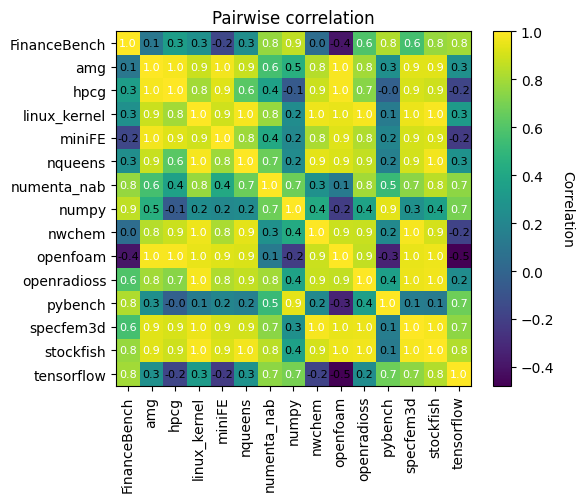

(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Pairwise correlation'}>)

In [69]:
plot_corr_heatmap(corr_matrix, colnames,savepath="../images/full_corr.png")

In [70]:
full_measurements = Scores[["FinanceBench","amg","numpy","hpcg","stockfish","nqueens","linux_kernel","pybench"]].dropna(how='any')
list(full_measurements.index)

['AMD Ryzen 7 3800XT x 1',
 'AMD Ryzen 7 5800X x 1',
 'AMD Ryzen 7 5800X3D x 1',
 'AMD Ryzen 7 7700X x 1',
 'AMD Ryzen 9 7900X x 1',
 'AMD Ryzen 9 7950X x 1',
 'Intel Xeon Silver 4216 x 1']

We will take "AMD Ryzen 7 7700X x 1" as our baseline CPU model. We will also restrict our measurements to: "FinanceBench","amg","numpy","hpcg","stockfish","nqueens","linux_kernel","pybench".

In [71]:
Considered_Tests = ["FinanceBench","amg","numpy","hpcg","stockfish","nqueens","linux_kernel","pybench"]
Baseline = Scores.loc["AMD Ryzen 7 7700X x 1"]
Baseline[Considered_Tests]

Test
FinanceBench   -10.370079
amg             19.741813
numpy            6.783325
hpcg             1.945910
stockfish       16.982270
nqueens         -2.397895
linux_kernel    -6.703188
pybench         -6.335054
Name: AMD Ryzen 7 7700X x 1, dtype: float64

In [72]:
baselined_scores = Scores[Considered_Tests]-Baseline[Considered_Tests]
reduced_columns = list(baselined_scores.columns)
corr_matrix, _ = pairwise_corr_with_missing(baselined_scores.to_numpy())

In [73]:
baselined_scores

Test,FinanceBench,amg,numpy,hpcg,stockfish,nqueens,linux_kernel,pybench
Model and Mult,,,,,,,,
AMD A10-7850K APU x 1,NaN,NaN,-1.908128,NaN,NaN,NaN,NaN,-1.167684
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,NaN,NaN,-1.856072,NaN,NaN,NaN,NaN,NaN
AMD A6-3410MX APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.172694
AMD Athlon 3000G x 1,NaN,NaN,-1.249936,NaN,NaN,NaN,NaN,-0.937344
AMD EPYC 4124P x 1,-0.387696,NaN,-0.232245,NaN,-0.803786,NaN,NaN,0.023319
...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,-1.563285,0.462425,-1.141418,0.451985,-0.564881,-0.087011,-0.154326,-0.851847
Intel Xeon W-1370P x 1,NaN,NaN,-0.423751,NaN,NaN,NaN,NaN,NaN
Intel Xeon W-2123 x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.974158


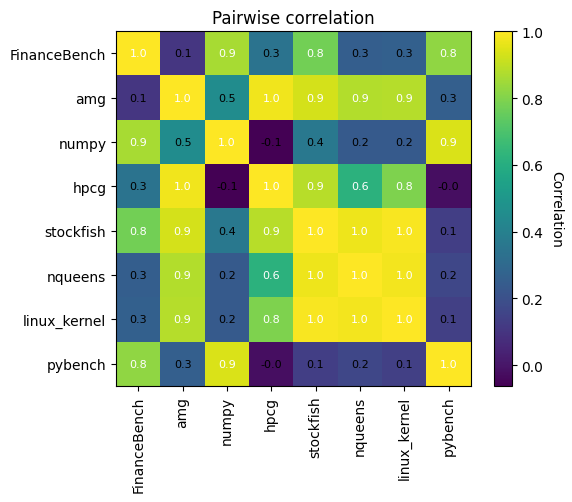

(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Pairwise correlation'}>)

In [74]:
plot_corr_heatmap(corr_matrix, reduced_columns,savepath="../images/reduced_corr.png")

### Construction of Target Variable

Conduct PCA scoring of the observations. Then, investigate the loadings for interpretation purposes. Finally, export for use in regression modeling.

In [75]:
def standardize_with_nan(X):
    X = np.array(X, dtype=float)
    mask_obs = ~np.isnan(X)

    means = np.nanmean(X, axis=0)
    stds  = np.nanstd(X, axis=0, ddof=1)

    # avoid division by zero
    stds_safe = np.where(stds == 0, 1.0, stds)

    X_std = (X - means) / stds_safe

    return X_std, means, stds_safe

def empca(X, n_components, max_iter=100, tol=1e-6, random_state=None, verbose=False):
    """
    EM-style PCA for data with missing values (NaNs).

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix with np.nan for missing entries.
    n_components : int
        Number of principal components to keep.
    max_iter : int, optional
        Maximum number of EM iterations.
    tol : float, optional
        Convergence threshold on RMSE change for missing entries.
    random_state : int or None
        Seed for small random perturbation in initialization.
    verbose : bool
        If True, print RMSE per iteration.

    Returns
    -------
    result : dict
        {
          "X_completed": completed data matrix,
          "mean": column means used for centering,
          "scores": PC scores (n_samples x n_components),
          "loadings": loadings (n_features x n_components),
          "singular_values": singular values,
          "explained_variance": variance per component,
          "explained_variance_ratio": proportion of variance per component,
          "n_iter": number of iterations run,
          "rmse_missing": final RMSE on missing entries,
          "mask_obs": boolean mask of observed entries
        }
    """
    X = np.array(X, dtype=float)
    n_samples, n_features = X.shape

    if n_components > min(n_samples, n_features):
        raise ValueError("n_components cannot exceed min(n_samples, n_features)")

    rng = np.random.default_rng(random_state)

    # True where observed, False where missing
    mask_obs = ~np.isnan(X)

    # Column means over observed entries
    col_means = np.nanmean(X, axis=0)

    # Initialize missing entries with column means (+ tiny noise if desired)
    X_filled = np.where(mask_obs, X, col_means)
    if random_state is not None:
        X_filled[~mask_obs] += 1e-6 * rng.standard_normal(np.sum(~mask_obs))

    prev_error = np.inf
    scores = None
    loadings = None
    mean = None
    S_k = None

    for it in range(max_iter):
        # Center on current completed matrix
        mean = X_filled.mean(axis=0, keepdims=True)
        Xc = X_filled - mean

        # PCA via SVD of centered data
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        U_k = U[:, :n_components]
        S_k = S[:n_components]
        Vt_k = Vt[:n_components, :]

        # Scores (n x k) and loadings (p x k)
        scores = U_k * S_k  # scales columns of U_k by singular values
        loadings = Vt_k.T   # (n_features x n_components)

        # Reconstruct low-rank approximation
        X_hat = scores @ loadings.T + mean

        # Update only missing entries
        X_new = X_filled.copy()
        X_new[~mask_obs] = X_hat[~mask_obs]

        # RMSE on missing entries as convergence metric
        if np.any(~mask_obs):
            diff = X_new[~mask_obs] - X_filled[~mask_obs]
            error = np.sqrt(np.mean(diff**2))
        else:
            error = 0.0

        if verbose:
            print(f"iter {it+1}, rmse_missing={error:.6e}")

        # Check convergence on change in RMSE
        if abs(prev_error - error) < tol:
            X_filled = X_new
            break

        X_filled = X_new
        prev_error = error

    # Final explained variance (on completed data)
    explained_variance = (S_k**2) / (n_samples - 1)
    explained_variance_ratio = explained_variance / explained_variance.sum()
    
    return {
        "X_completed": X_filled,
        "mean": mean.ravel(),
        "scores": scores,
        "loadings": loadings,
        "singular_values": S_k,
        "explained_variance": explained_variance,
        "explained_variance_ratio": explained_variance_ratio,
        "n_iter": it + 1,
        "rmse_missing": error,
        "mask_obs": mask_obs,
    }

### What particular property of the above algorithm leads to changes in the PCs as number of components changes?

In [76]:
X_std, x_means, x_stds = standardize_with_nan(baselined_scores.to_numpy()) 
res = empca(X_std, n_components=1, verbose=False,max_iter=1000, random_state=42)
print(reduced_columns)
res['loadings']

['FinanceBench', 'amg', 'numpy', 'hpcg', 'stockfish', 'nqueens', 'linux_kernel', 'pybench']


array([[0.45926944],
       [0.28953568],
       [0.25795453],
       [0.38585025],
       [0.36037151],
       [0.36039003],
       [0.43579783],
       [0.20037807]])

In [77]:
### We need to assess performance
X_std, x_means, x_stds = standardize_with_nan(baselined_scores.to_numpy())

res1 = empca(
    X_std,
    n_components=1,
    max_iter=1000,
    tol=1e-6,
    random_state=42,
    verbose=False
)

load1   = res1["loadings"][:, 0]          # (p,)
scores1 = res1["scores"][:, 0]            # (n,)
mean1   = res1["mean"]                    # (p,)
mask    = res1["mask_obs"]                # (n, p) bool, True where observed

X_hat1 = np.outer(scores1, load1) + mean1  # shape (n, p)

# Original standardized matrix (with NaNs)
X_orig = X_std

# Select only observed entries for error calculation
diff = X_orig - X_hat1

# Flatten the observed entries
err_obs  = diff[mask]
orig_obs = X_orig[mask]

SSE = np.sum(err_obs**2)
SST = np.sum(orig_obs**2)

R2_pc1 = 1.0 - SSE / SST
pct_pc1 = R2_pc1 * 100

print(f"PC1 explains about {pct_pc1:.2f}% of the variance in the original (incomplete) standardized data.")

PC1 explains about 78.79% of the variance in the original (incomplete) standardized data.


We can see that the loading is positive for all tests, this indicates that it may be reasonable to interpret the PC1 as a generalized performance index across tests.

We want to do a quick check regarding the validity of this approximation. We should see that the first PC increases with time (as test scores generally do).

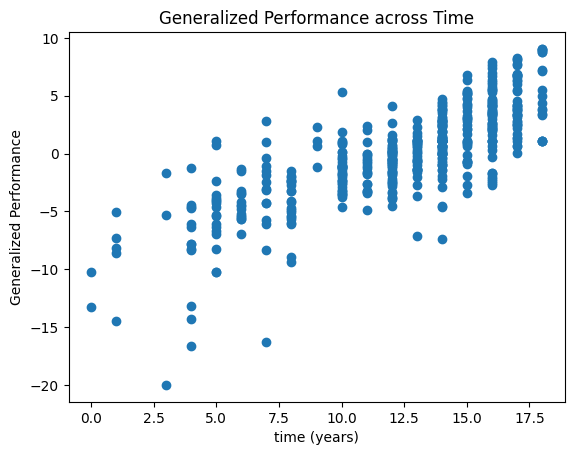

In [78]:
plt.plot(Explanatory_Variables['time'],res['scores'],linestyle="None",marker="o")
plt.title("Generalized Performance across Time")
plt.ylabel("Generalized Performance")
plt.xlabel("time (years)")
plt.savefig("../images/Generalized_Performance_across_time.png")

Now we should construct our final dataset. We may still end up filling in additional measurements as possible.

In [79]:
Explanatory_Variables['Generalized Performance']=res['scores']
Explanatory_Variables

,Multiplier,Brand,process_size,transistors,frequency,tdp,memory_bandwidth,#_of_cores,year,time,launch_price,market,Generalized Performance
Model and Mult,,,,,,,,,,,,,
AMD A10-7850K APU x 1,1,AMD,28,2411.0,3.700,95,NaN,4.0,2014,7,NaN,Desktop,-8.341803
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,1,AMD,28,2411.0,3.900,95,34.1,4.0,2015,8,NaN,Desktop,-8.940792
AMD A6-3410MX APU x 1,1,AMD,32,1178.0,NaN,45,NaN,4.0,2011,4,NaN,Mobile,-16.637069
AMD Athlon 3000G x 1,1,AMD,14,4950.0,3.500,35,42.7,2.0,2019,12,49.0,Desktop,-3.913631
AMD EPYC 4124P x 1,1,AMD,5,6570.0,3.800,65,83.2,4.0,2024,17,149.0,Server/Workstation,2.424266
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,1,Intel,14,8000.0,2.100,85,NaN,12.0,2017,10,NaN,Server/Workstation,-0.255378
Intel Xeon W-1370P x 1,1,Intel,14,NaN,3.600,125,51.2,8.0,2021,14,428.0,Server/Workstation,3.481962
Intel Xeon W-2123 x 1,1,Intel,14,NaN,3.600,120,85.3,4.0,2017,10,294.0,Server/Workstation,-4.652512


### Partially Update Data Manually

At this point, we manually updated some launch price and memory bandwidth data by manual search and replace.

As such, we need to reload and merge the updates.



In [80]:
revised_data = pd.read_csv("../data/Regression_Data_Revised.csv",index_col="Model and Mult")
revised_data["launch_price"]

Model and Mult
AMD A10-7850K APU x 1                                  173.0
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1     137.0
AMD A6-3410MX APU x 1                                  295.0
AMD Athlon 3000G x 1                                    49.0
AMD EPYC 4124P x 1                                     149.0
                                                       ...  
Intel Xeon Silver 4216 x 1                               NaN
Intel Xeon W-1370P x 1                                 428.0
Intel Xeon W-2123 x 1                                  294.0
Intel Xeon W-2295 x 1                                 2553.0
Intel Xeon X5675 x 2                                     NaN
Name: launch_price, Length: 482, dtype: float64

In [81]:
Explanatory_Variables["launch_price"]

Model and Mult
AMD A10-7850K APU x 1                                    NaN
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1       NaN
AMD A6-3410MX APU x 1                                    NaN
AMD Athlon 3000G x 1                                    49.0
AMD EPYC 4124P x 1                                     149.0
                                                       ...  
Intel Xeon Silver 4216 x 1                               NaN
Intel Xeon W-1370P x 1                                 428.0
Intel Xeon W-2123 x 1                                  294.0
Intel Xeon W-2295 x 1                                 2553.0
Intel Xeon X5675 x 2                                     NaN
Name: launch_price, Length: 485, dtype: float64

In [82]:
Explanatory_Variables["launch_price"]=revised_data["launch_price"]
Explanatory_Variables["memory_bandwidth"]=revised_data["memory_bandwidth"]

In [83]:
Explanatory_Variables["launch_price"]

Model and Mult
AMD A10-7850K APU x 1                                  173.0
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1     137.0
AMD A6-3410MX APU x 1                                  295.0
AMD Athlon 3000G x 1                                    49.0
AMD EPYC 4124P x 1                                     149.0
                                                       ...  
Intel Xeon Silver 4216 x 1                               NaN
Intel Xeon W-1370P x 1                                 428.0
Intel Xeon W-2123 x 1                                  294.0
Intel Xeon W-2295 x 1                                 2553.0
Intel Xeon X5675 x 2                                     NaN
Name: launch_price, Length: 485, dtype: float64

### Ground Latent Variable

In [84]:
baselined_scores

Test,FinanceBench,amg,numpy,hpcg,stockfish,nqueens,linux_kernel,pybench
Model and Mult,,,,,,,,
AMD A10-7850K APU x 1,NaN,NaN,-1.908128,NaN,NaN,NaN,NaN,-1.167684
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,NaN,NaN,-1.856072,NaN,NaN,NaN,NaN,NaN
AMD A6-3410MX APU x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.172694
AMD Athlon 3000G x 1,NaN,NaN,-1.249936,NaN,NaN,NaN,NaN,-0.937344
AMD EPYC 4124P x 1,-0.387696,NaN,-0.232245,NaN,-0.803786,NaN,NaN,0.023319
...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,-1.563285,0.462425,-1.141418,0.451985,-0.564881,-0.087011,-0.154326,-0.851847
Intel Xeon W-1370P x 1,NaN,NaN,-0.423751,NaN,NaN,NaN,NaN,NaN
Intel Xeon W-2123 x 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.974158


In [85]:
Explanatory_Variables["Generalized Performance"]

Model and Mult
AMD A10-7850K APU x 1                                 -8.341803
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1    -8.940792
AMD A6-3410MX APU x 1                                -16.637069
AMD Athlon 3000G x 1                                  -3.913631
AMD EPYC 4124P x 1                                     2.424266
                                                        ...    
Intel Xeon Silver 4216 x 1                            -0.255378
Intel Xeon W-1370P x 1                                 3.481962
Intel Xeon W-2123 x 1                                 -4.652512
Intel Xeon W-2295 x 1                                 -0.448470
Intel Xeon X5675 x 2                                  -1.213279
Name: Generalized Performance, Length: 485, dtype: float64

In [86]:
valid_measures = baselined_scores[["amg","numpy"]].index
baselined_scores_valid = baselined_scores[["amg", "numpy"]].notna().all(axis=1)
subdata = baselined_scores[baselined_scores_valid][["amg","numpy"]].copy()
grounded_val = subdata.mean(axis=1)

In [87]:
print(Explanatory_Variables.loc[baselined_scores_valid, "Generalized Performance"].values.shape)
x = Explanatory_Variables.loc[baselined_scores_valid, "Generalized Performance"].values
X = np.column_stack([np.ones(x.shape), x])
y = grounded_val

alpha_hat, beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]
print(alpha_hat)
print(beta_hat)

(161,)
-0.3963077361803541
0.20969663036870992


In [88]:
Explanatory_Variables["Performance"]=alpha_hat + beta_hat * Explanatory_Variables["Generalized Performance"]
Explanatory_Variables["Performance"]

Model and Mult
AMD A10-7850K APU x 1                                -2.145556
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1   -2.271162
AMD A6-3410MX APU x 1                                -3.885045
AMD Athlon 3000G x 1                                 -1.216983
AMD EPYC 4124P x 1                                    0.112053
                                                        ...   
Intel Xeon Silver 4216 x 1                           -0.449860
Intel Xeon W-1370P x 1                                0.333848
Intel Xeon W-2123 x 1                                -1.371924
Intel Xeon W-2295 x 1                                -0.490350
Intel Xeon X5675 x 2                                 -0.650728
Name: Performance, Length: 485, dtype: float64

In [89]:
Explanatory_Variables[reduced_columns]=baselined_scores.values
Explanatory_Variables

,Multiplier,Brand,process_size,transistors,frequency,tdp,memory_bandwidth,#_of_cores,year,time,...,Generalized Performance,Performance,FinanceBench,amg,numpy,hpcg,stockfish,nqueens,linux_kernel,pybench
Model and Mult,,,,,,,,,,,,,,,,,,,,,
AMD A10-7850K APU x 1,1,AMD,28,2411.0,3.700,95,34.1,4.0,2014,7,...,-8.341803,-2.145556,NaN,NaN,-1.908128,NaN,NaN,NaN,NaN,-1.167684
AMD A10-7870K Radeon R7 12 Compute Cores 4C+8G x 1,1,AMD,28,2411.0,3.900,95,34.1,4.0,2015,8,...,-8.940792,-2.271162,NaN,NaN,-1.856072,NaN,NaN,NaN,NaN,NaN
AMD A6-3410MX APU x 1,1,AMD,32,1178.0,NaN,45,25.6,4.0,2011,4,...,-16.637069,-3.885045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.172694
AMD Athlon 3000G x 1,1,AMD,14,4950.0,3.500,35,42.7,2.0,2019,12,...,-3.913631,-1.216983,NaN,NaN,-1.249936,NaN,NaN,NaN,NaN,-0.937344
AMD EPYC 4124P x 1,1,AMD,5,6570.0,3.800,65,83.2,4.0,2024,17,...,2.424266,0.112053,-0.387696,NaN,-0.232245,NaN,-0.803786,NaN,NaN,0.023319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Intel Xeon Silver 4216 x 1,1,Intel,14,8000.0,2.100,85,NaN,12.0,2017,10,...,-0.255378,-0.449860,-1.563285,0.462425,-1.141418,0.451985,-0.564881,-0.087011,-0.154326,-0.851847
Intel Xeon W-1370P x 1,1,Intel,14,NaN,3.600,125,51.2,8.0,2021,14,...,3.481962,0.333848,NaN,NaN,-0.423751,NaN,NaN,NaN,NaN,NaN
Intel Xeon W-2123 x 1,1,Intel,14,NaN,3.600,120,85.3,4.0,2017,10,...,-4.652512,-1.371924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.974158


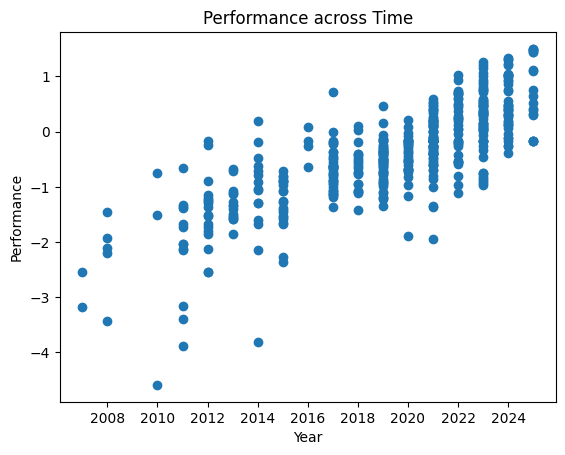

In [90]:
plt.plot(Explanatory_Variables['time']+2007,Explanatory_Variables["Performance"],linestyle="None",marker="o")
plt.title("Performance across Time")
plt.ylabel("Performance")
plt.xticks([2008,2010,2012,2014,2016,2018,2020,2022,2024])
plt.xlabel("Year")
plt.savefig("../images/Corrected_Generalized_Performance_across_time.png")

In [91]:
Explanatory_Variables.to_csv("../data/Regression_Data.csv")